# **Behavioural Cloning**

In [1]:
!git clone https://github.com/absolutelynick/machine_learning_drive_data.git
  
!ls

!pip3 install imgaug

Cloning into 'machine_learning_drive_data'...
remote: Enumerating objects: 25161, done.
remote: Counting objects: 100% (25161/25161), done.
remote: Compressing objects: 100% (25161/25161), done.
remote: Total 137041 (delta 0), reused 25159 (delta 0), pack-reused 111880
Receiving objects: 100% (137041/137041), 1.48 GiB | 31.24 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (137023/137023), done.
machine_learning_drive_data  sample_data
    100% |████████████████████████████████| 17.3MB 2.8MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


##**Gathering the Python frameworks needed**

In [2]:
# Importing all the needed information from the image data


import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

# Setting a consistant seed

np.random.seed(0)

Using TensorFlow backend.


##**Display the first set of CSV data**

In [3]:
# TODO remove the Track from the path when I am near wifi

datadir = 'machine_learning_drive_data/image_data'

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)

pd.set_option('display.max_colwidth', -1)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Nick\Desktop\driving_images\IMG\center_2019_04_01_19_21_05_834.jpg,C:\Users\Nick\Desktop\driving_images\IMG\left_2019_04_01_19_21_05_834.jpg,C:\Users\Nick\Desktop\driving_images\IMG\right_2019_04_01_19_21_05_834.jpg,0.0,0.0,0.0,1.686586
1,C:\Users\Nick\Desktop\driving_images\IMG\center_2019_04_01_19_21_05_923.jpg,C:\Users\Nick\Desktop\driving_images\IMG\left_2019_04_01_19_21_05_923.jpg,C:\Users\Nick\Desktop\driving_images\IMG\right_2019_04_01_19_21_05_923.jpg,0.0,0.0,0.0,1.673031
2,C:\Users\Nick\Desktop\driving_images\IMG\center_2019_04_01_19_21_06_013.jpg,C:\Users\Nick\Desktop\driving_images\IMG\left_2019_04_01_19_21_06_013.jpg,C:\Users\Nick\Desktop\driving_images\IMG\right_2019_04_01_19_21_06_013.jpg,0.0,0.0,0.0,1.656241
3,C:\Users\Nick\Desktop\driving_images\IMG\center_2019_04_01_19_21_06_105.jpg,C:\Users\Nick\Desktop\driving_images\IMG\left_2019_04_01_19_21_06_105.jpg,C:\Users\Nick\Desktop\driving_images\IMG\right_2019_04_01_19_21_06_105.jpg,0.0,0.0,0.0,1.642931
4,C:\Users\Nick\Desktop\driving_images\IMG\center_2019_04_01_19_21_06_195.jpg,C:\Users\Nick\Desktop\driving_images\IMG\left_2019_04_01_19_21_06_195.jpg,C:\Users\Nick\Desktop\driving_images\IMG\right_2019_04_01_19_21_06_195.jpg,0.0,0.0,0.0,1.626443


##**Split the first section of the path from our desktop rendering of the image**

In [4]:

def pathClean(path):
  """ Cleaning the first section of desktop path from rendering all the data. """
  head, tail = ntpath.split(path)
  return tail

# Applying the clean function to all of the paths

data["center"] = data["center"].apply(pathClean)
data["left"]   = data["left"].apply(pathClean)
data["right"]  = data["right"].apply(pathClean)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_04_01_19_21_05_834.jpg,left_2019_04_01_19_21_05_834.jpg,right_2019_04_01_19_21_05_834.jpg,0.0,0.0,0.0,1.686586
1,center_2019_04_01_19_21_05_923.jpg,left_2019_04_01_19_21_05_923.jpg,right_2019_04_01_19_21_05_923.jpg,0.0,0.0,0.0,1.673031
2,center_2019_04_01_19_21_06_013.jpg,left_2019_04_01_19_21_06_013.jpg,right_2019_04_01_19_21_06_013.jpg,0.0,0.0,0.0,1.656241
3,center_2019_04_01_19_21_06_105.jpg,left_2019_04_01_19_21_06_105.jpg,right_2019_04_01_19_21_06_105.jpg,0.0,0.0,0.0,1.642931
4,center_2019_04_01_19_21_06_195.jpg,left_2019_04_01_19_21_06_195.jpg,right_2019_04_01_19_21_06_195.jpg,0.0,0.0,0.0,1.626443


##**Checking the data that we have for bias within the steering**

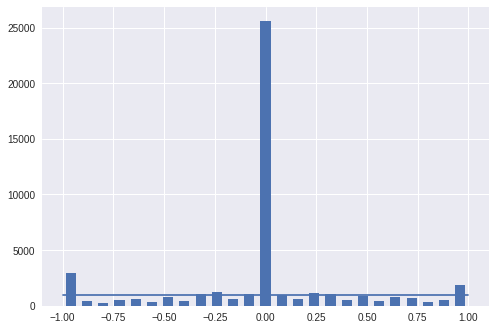

In [5]:
num_bins = 25
samples_per_bin = 1000

hist, bins = np.histogram(data["steering"], num_bins)

center = (bins[:-1]+bins[1:]) * 0.5

# Setting the bar width for the graph

plt.bar(center, hist, width=0.05)

# Plotting a line that we can see the best plot for all the data

plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

plt.show()

##**Flattening and shuffling the data in our set**

In [0]:
# If our data falls between the limits that we stated below then we will append
# that item.

remove_list = list()

for j in range(num_bins):
  
  list_ = list()
  
  for i in range(len(data["steering"])):
    
    if (data["steering"][i] >= bins[j]) and (data["steering"][i] <= bins[j+1]):
      
      list_.append(i)
      
  # Shuffling the data
  # So when we lower the list size our data will not become scewed
  # missing the last sections of the track for example.
      
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)


##**Plotting the new data that we have sanitised**

Removed:  27968
Remaining: 17704 



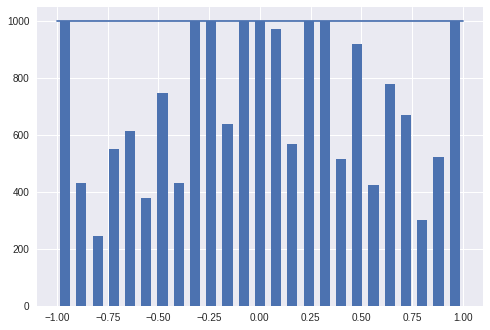

In [7]:
print( "Removed: ", len(remove_list) )
data.drop(data.index[remove_list], inplace=True)
print( "Remaining: %s \n" % len(data) )

hist, _ = np.histogram(data["steering"], (num_bins))

# Setting the bar width for the graph

plt.bar(center, hist, width=0.05)

# Plotting a line that we can see the best plot for all the data

plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin))

plt.show()

##**Training our validation data**

In [8]:
# Our new dataset example

print(data.iloc[1])

def load_img_steering(datadir, df):
  """ Gathering and randomising the new data array for validation. """
  
  image_path = list()
  steering = list()
  
  # Adding some new lists with all the steering angles
  
  for i in range(len(data)):
    
    indexed_data = data.iloc[i]
    
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2], 
    
    image_path.append( os.path.join(datadir, center.strip() ) )
    
    steering.append(float(indexed_data[3]))
    
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
    
  return image_paths, steerings
  
image_paths, steerings = load_img_steering(datadir + "/IMG", data)

center      center_2019_04_01_19_21_06_917.jpg
left        left_2019_04_01_19_21_06_917.jpg  
right       right_2019_04_01_19_21_06_917.jpg 
steering    0.15                              
throttle    1                                 
reverse     0                                 
speed       4.40416                           
Name: 12, dtype: object


##**Gathering our new data and randomising it use**

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split( image_paths, steerings, test_size=0.2, random_state=6 )

print("Training samples: %s \nValid Samples: %s" % ( len(x_train), len(x_valid) ) )

Training samples: 14163 
Valid Samples: 3541


##**Plotting our new data**

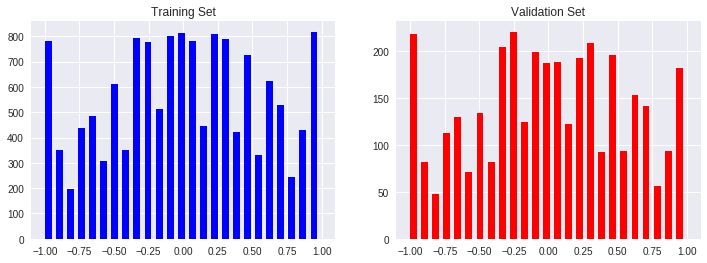

In [10]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist( y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title( "Training Set" )
axes[1].hist( y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title( "Validation Set" )
plt.show()

##**Creating our new variation data sets from our small data pool**
* These are generated from the random ranges given for brightness
* They are consistant for zoom, pan and flip

##Zoom

In [0]:
def zoom(image):
  """ Zooming in from 0 to 30% of the image. """
  
  zoom = iaa.Affine(scale=(1,1.3))
  
  image = zoom.augment_image(image)
  
  return image

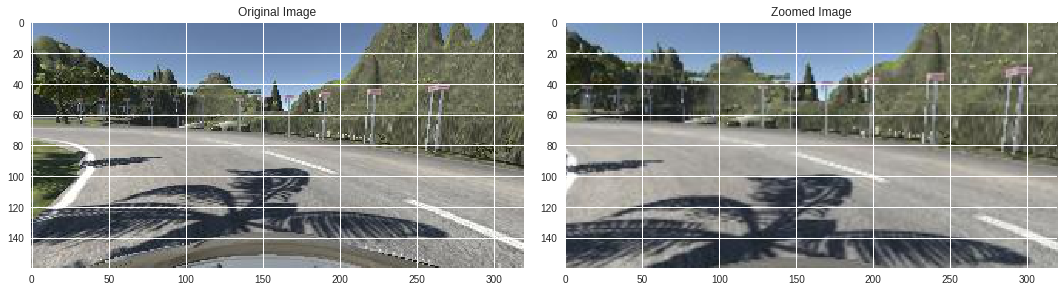

In [12]:
# Showing the image that we have appended

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

plt.show()

##Panning

In [0]:
def pan(image):
  """ Panning in on the image to make it more variated. Horizontal or Vertical Panning. """
  
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  
  image = pan.augment_image(image)
  
  return image

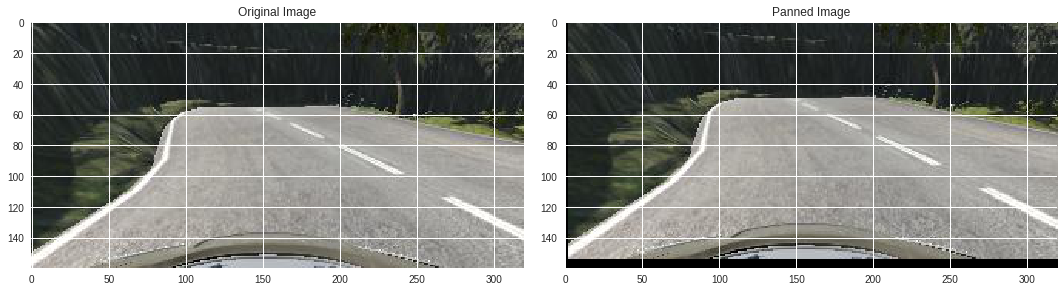

In [14]:
# Showing the image that we have appended

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

plt.show()

##Brightness

In [0]:
def img_random_brightness(image):
    """ Helping our model to see in dark and bright situations. """
    
    iaa_image = iaa.Multiply((0.2, 1.2))
    
    appended_image = iaa_image.augment_image(image)
    
    return appended_image


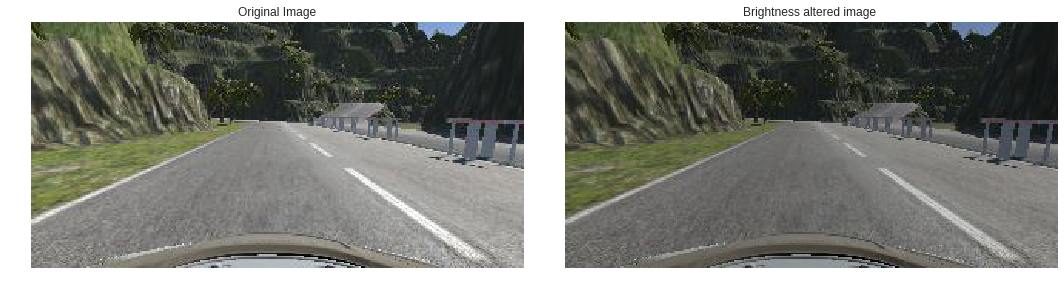

In [16]:
# Showing the image that we have appended
  
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')
axs[1].axis('off')

plt.show()

##Flipping (image and steering angle)

In [0]:
def img_random_flip(image, steering_angle):
    """ Flipping the image horizontally. """
  
    image = cv2.flip(image,1)
    
    steering_angle = -steering_angle
    
    return image, steering_angle
  
random_index = random.randint(0, 1000)

image = image_paths[random_index]

steering_angle = steerings[random_index]

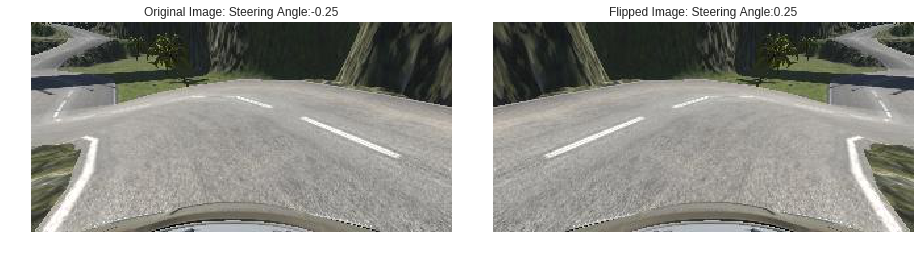

In [18]:
# Showing the image that we have appended

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(13, 8))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image: Steering Angle:' + str(steering_angle))
axs[0].axis('off')

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image: Steering Angle:' + str(flipped_steering_angle))
axs[1].axis('off')

plt.show()

##**Randomly appending an image**

In [0]:
def random_augment(image, steering_angle):
  """ Returns an image with up to 4 changes applied to it. """
  image = mpimg.imread(image)
  
  # Start passing the image through these args
  
  if np.random.rand() < 0.5:
    image = pan(image)
    
  if np.random.rand() < 0.5:
    image = zoom(image)
  
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)

  return image, steering_angle

##**Showing our Augmented images**

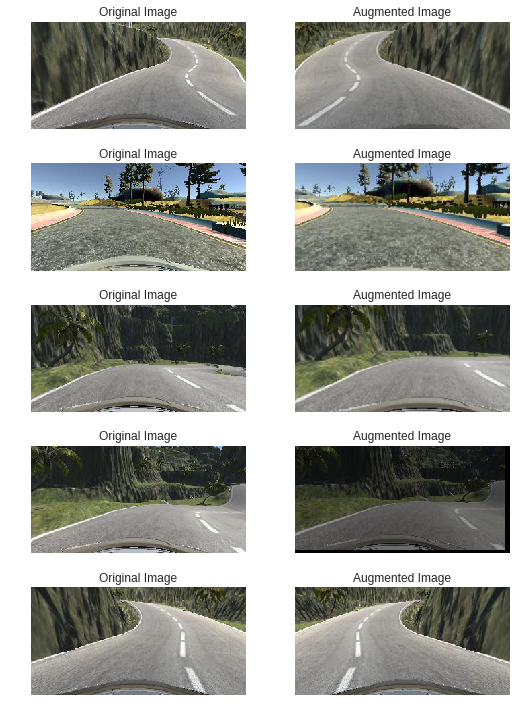

In [20]:
ncol, nrow = 2, 5

fig, axs = plt.subplots(nrow, ncol, figsize=(7.5,10))
fig.tight_layout()

for i in range(5):
  
  randNum = random.randint(0, len(image_paths) - 1)
  
  random_image = image_paths[randNum]
  random_steering = steerings[randNum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  # Showing our original image
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title( "Original Image" )
  axs[i][0].axis("off")
  
  # Showing our augmented image

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title( "Augmented Image" )
  axs[i][1].axis("off")

plt.show()  

##**Preprocessing our images ready for scanning by our neural network**

In [0]:
def img_preprocess(img):
  """ Using matplotlib to normalise our images """
  
  # Image scale to remove the area above the road
  cropped_img = img[60:135,:,:]
  
  # YUV colour space recommended by NVidia rather than RGB for images
  yuv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2YUV)
  
  # Reducing noise and smoothing areas
  blur_img = cv2.GaussianBlur(yuv_img, (3,3), 0)
  
  # Resize the image
  scale_img = cv2.resize(blur_img, (200,66))
  
  # Normalisation process and return
  
  return scale_img/255
  

## **Testing an image**

In [0]:
image = image_paths[100]

original_image = mpimg.imread(image)

preprocesed_image = img_preprocess(original_image)

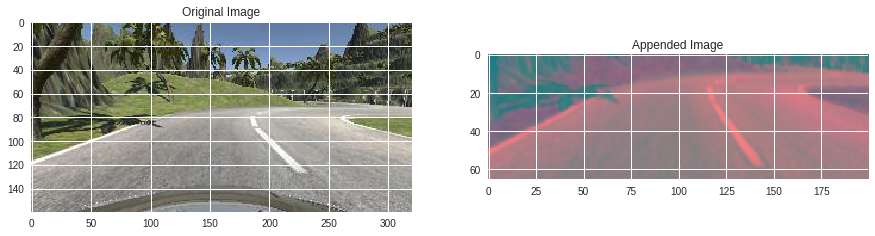

In [23]:
fig, axes = plt.subplots(1,2,figsize=(15,10))
axes[0].imshow(original_image)
axes[0].set_title( "Original Image" )
axes[1].imshow(preprocesed_image)
axes[1].set_title( "Appended Image" )
plt.show()

##**Creating a generator to yeild the Augmented data**

* This will save memory as it will not need the data to be stored

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, isTraining):
  """ This will yield our data needed to increase our data set. """

  while True:
    
      batch_img = list()
      batch_steering = list()

      for i in range(batch_size):

          random_index = random.randint(0, len(image_paths) - 1)

          if isTraining:
              im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

          else:
              im = mpimg.imread(image_paths[random_index])
              steering = steering_ang[random_index]

          im = img_preprocess(im)
          batch_img.append(im)
          batch_steering.append(steering)
      
      yield (np.asarray(batch_img), np.asarray(batch_steering))

##**The new generated training data**

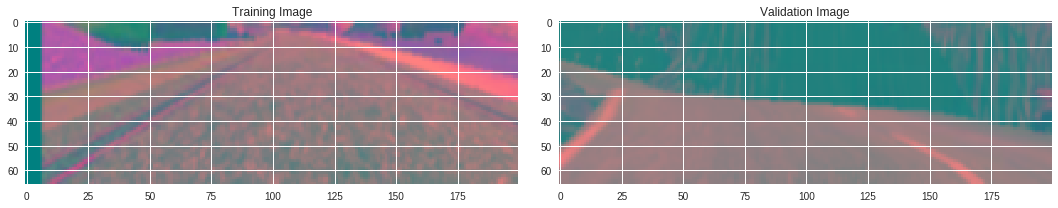

In [25]:
# Storing the yeilded values below to test

x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

plt.show()

##**Nvidea End to End Learning for Self Driving Cars**

https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

![Model IImage](https://liwanggt.github.io/images/CNN_NVIDIA.png)

In [0]:
def nvidia_model():
  
  model = Sequential()
  
  # SubSample will move the scanning 2 picels at a time
  # Instead of using "Relu" we will use "elu" as is will be less likely to fail
  # Elu handles Polynomial Regression with minus outputs unlike Relu's Linear 0-1
  
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))

  model.add(Flatten())
  
  # Not using a dropout as this caused a false negative on the data reading.
  
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
  
  # Using low learning rate to prevent over fitting
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

##**Our new model for our self driving car**

In [27]:
# Using the nVidia module to make the Keras calculation
# Used for behavioural models that need regression based models

model = nvidia_model()

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to th

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [28]:
# New model using our batch gen to make a larger data set

# Get the model if it just needs testing

modelHistory = model.fit_generator(batch_generator(x_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(x_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=True,
                                  shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
300/300 [==============================] - 161s 537ms/step - loss: 0.2627 - val_loss: 0.3320
Epoch 2/10
300/300 [==============================] - 155s 518ms/step - loss: 0.1839 - val_loss: 0.1548
Epoch 3/10
300/300 [==============================] - 155s 518ms/step - loss: 0.1569 - val_loss: 0.1243
Epoch 4/10
300/300 [==============================] - 156s 519ms/step - loss: 0.1430 - val_loss: 0.1256
Epoch 5/10
300/300 [==============================] - 155s 518ms/step - loss: 0.1317 - val_loss: 0.1117
Epoch 6/10
300/300 [==============================] - 155s 515ms/step - loss: 0.1277 - val_loss: 0.1063
Epoch 7/10
300/300 [==============================] - 156s 520ms/step - loss: 0.1245 - val_loss: 0.1041
Epoch 8/10
300/300 [==============================] - 156s 521ms/step - loss: 0.1193 - val_loss: 0.1032
Epoch 9/10
300/300 [==============================] - 156s 520ms/step - loss: 0.1150 - val_loss: 0.1032
Epoch 10/10
300/

##**Showing model build loss**

Text(0.5, 0, 'Epoch')

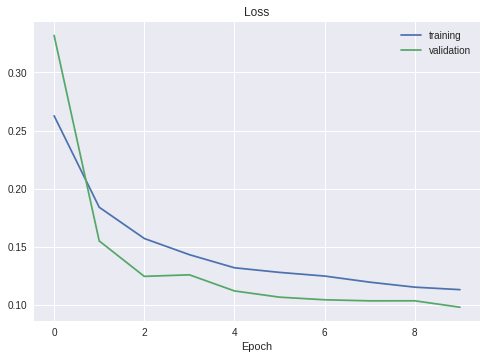

In [29]:
plt.plot(modelHistory.history['loss'])
plt.plot(modelHistory.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

##**Saving out our model locally to the project**

In [0]:
model.save('model.h5')

##**Saving out our model to disk for testing**

In [0]:
from google.colab import files

# I don't need to save this each time

if True:
  
  files.download('model.h5')

##**Running the saved machine learning model locally with socketIO**




1. #### In an anaconda shell to install all packages
``
conda install -c conda-forge eventlet
conda install -c conda-forge python-socketio
``
2. #### Create my own evviroment
``
create --name myenviron
``
3. #### Running it on windows
``
activate myenviron
``
4. #### Run drive.py to open the socket and test
``python drive.py

``


##**Testing on a random image and making a prediction**

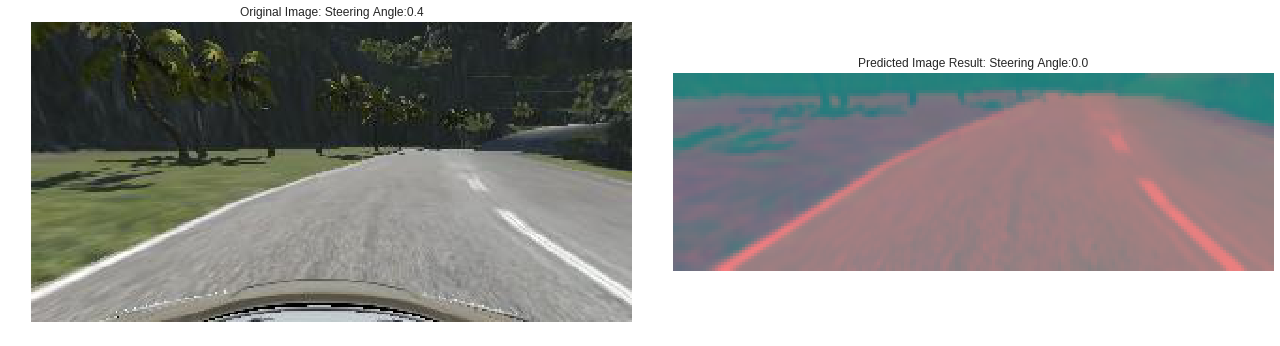

In [32]:
# Getting a random image

rand_int = random.randint(0, len(image_paths) - 1)

# Getting the original image

rand_image = mpimg.imread(image_paths[rand_int])

# Getting the predicted image

rand_image = np.asarray(rand_image)
predicted_image = img_preprocess(rand_image)

# Getting our angle prediction

predicted_angle = float(model.predict_classes(np.array([predicted_image])))
steering_angle = steerings[rand_int]

# Show the original image with the predicted image

fig, axs = plt.subplots(1, 2, figsize=(18, 13))
fig.tight_layout()

axs[0].imshow(rand_image)
axs[0].set_title('Original Image: Steering Angle:' + str(steering_angle))
axs[0].axis('off')

axs[1].imshow(predicted_image)
axs[1].set_title('Predicted Image Result: Steering Angle:' + str(predicted_angle))
axs[1].axis('off')

plt.show()